In [ ]:
# ROSSMANN SALES SOLUTION

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

IMPORTS

In [1]:
!pip install bentoml

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path
import PIL
import json
from fastai import *
from fastai.tabular import *



**LOAD KAGGLE DATASET**

In [4]:
PATH = Path('rossmann/')
PATH


PosixPath('rossmann')

In [4]:
!ls

__MACOSX                    rossman_sales_bentoml.ipynb
external                    rossmann
rossman_data_clean.ipynb


**LOAD INTO DATAFRAME**

In [5]:
train_df = pd.read_pickle(PATH/'train_clean')

In [6]:
test_df = pd.read_pickle(PATH/'test_clean')

In [7]:
procs = [FillMissing, Categorify, Normalize]

In [8]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [9]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [10]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [11]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [12]:
valid_idx = range(cut)

In [13]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [14]:
train_df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,5263,555,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,1,2,5,2015-07-31,6064,625,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,2,3,5,2015-07-31,8314,821,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,3,4,5,2015-07-31,13995,1498,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,4,5,5,2015-07-31,4822,559,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [15]:
data = (TabularList.from_df(df, path=PATH, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=PATH, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())


In [16]:
print(data.train_ds.cont_names)  

['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE', 'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']


In [17]:
(cat_x,cont_x),y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(to_np(o[:5]))

[[475   6   2  10 ...   6   1   1   2]
 [837   4   2   9 ...   1   1   1   1]
 [285   1   2   2 ...   1   1   1   1]
 [ 87   1   2  10 ...   6   2   1   1]
 [519   4   1  11 ...   1   1   1   1]]
[[-0.680619  0.854898  1.032151  1.01791  ... -1.175229  0.322324 -0.899394 -0.479577]
 [ 1.172429  0.494103  0.468278  0.544769 ...  1.889272  0.938366 -0.899394 -0.479577]
 [-0.389718 -1.069343 -1.082373 -1.19008  ... -0.16426  -1.094575  1.111858 -0.479577]
 [-0.626796  0.373838  0.609246  1.01791  ... -0.669745 -0.848158  1.111858  2.085166]
 [-0.376903 -0.588283 -0.377532  0.071628 ...  0.562374  0.353126 -0.899394 -0.479577]]
[8.965335 8.069029 8.691818 9.000977 8.719645]


DEFINING THE MODEL

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [19]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [20]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [21]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


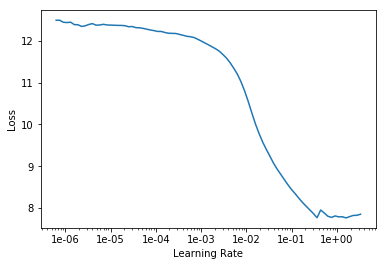

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(1, 1e-04 , wd = 0.2)
#wd=0.2


epoch,train_loss,valid_loss,exp_rmspe,time
0,0.026817,0.022727,0.150182,12:53


In [24]:
learn.show_results()

Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw,CompetitionDistance_na,CloudCover_na,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,target,prediction
1,5,2015,7,31,False,24,0,c,a,#na#,2008,1900,HE,31,Fog,5.0,5.0,0.0,0.0,7.0,5.0,False,False,-0.5358,1.0954,0.8912,0.3871,0.6029,-1.5678,-1.6598,0.1549,-0.1452,-2.8229,1.8567,1.8939,0.5940,1.1848,1.1119,2.0852,8.568457,[8.788032]
2,5,2015,7,31,False,24,25,a,a,"Jan,Apr,Jul,Oct",2007,2010,TH,31,Fog,1.0,5.0,0.0,0.0,1.0,5.0,False,False,-0.6255,0.6144,0.4683,0.2293,0.8653,-0.9545,-1.3033,-0.9548,-0.1452,-0.9761,1.4035,1.8939,0.9099,1.1848,1.1119,2.0852,8.710125,[8.897844]
3,5,2015,7,31,False,24,25,a,a,"Jan,Apr,Jul,Oct",2006,2011,NW,31,Fog,5.0,5.0,0.0,0.0,5.0,5.0,False,False,1.1122,0.8549,0.4683,0.0716,0.8653,-1.0312,-1.3542,-0.9548,-1.1514,-2.2073,1.9473,1.8939,0.5940,1.1848,1.1119,2.0852,9.025696,[9.166245]
4,5,2015,7,31,False,24,0,c,c,#na#,2009,1900,BE,31,#na#,1.0,5.0,0.0,0.0,1.0,5.0,False,False,-0.6191,0.6144,0.6092,0.5448,0.0780,-1.0312,-1.0487,0.0439,0.6933,0.2552,0.8597,1.8939,0.9099,1.1848,1.1119,2.0852,9.546455,[9.296576]
5,5,2015,7,31,False,3,0,a,a,#na#,2015,1900,SN,31,#na#,1.0,5.0,0.0,0.0,1.0,5.0,False,False,3.1344,0.7346,0.7502,0.7025,-1.4966,-1.4912,-1.2524,-0.9548,-0.1452,-0.9761,1.5848,1.8939,0.5940,1.1848,1.1119,2.0852,8.480944,[8.742598]


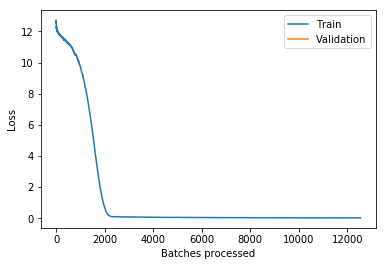

In [25]:
learn.recorder.plot_losses()

In [26]:
row = df.iloc[0]

In [27]:
learn.predict(row)

(FloatItem [8.788031], tensor([8.7880]), tensor([8.7880]))

In [32]:
test_df.to_csv('test_clean.csv')

In [28]:
!ls

__MACOSX                    rossmann
__pycache__                 rossmann_sales.py
external                    test.csv
rossman_data_clean.ipynb    test.json
rossman_sales_bentoml.ipynb test_clean.csv


In [29]:
%%writefile rossmann_sales.py

from bentoml import BentoService, api, env, artifacts
from bentoml.artifact import FastaiModelArtifact
from bentoml.handlers import DataframeHandler

#@env(conda_pip_dependencies=['fastai'])
@env(conda_environment=['fastai'])
@artifacts([FastaiModelArtifact('rossmann')])

class RossmannSales(BentoService):
    
    @api(DataframeHandler)
    def predict(self,df):
        result = []
        for index, row in df.iterrows():            
            result.append(self.artifacts.rossmann.predict(row))
        return str(result)

Overwriting rossmann_sales.py


In [30]:
from rossmann_sales import RossmannSales

service = RossmannSales.pack(rossmann=learn)
saved_path = service.save('/tmp/bento_archive')

print(saved_path)

[2019-07-21 22:18:51,558] INFO - Searching for dependant modules of rossmann_sales:/Users/mac/tabular/rossmann_sales.py
[2019-07-21 22:19:15,216] INFO - Copying local python module '/Users/mac/tabular/rossmann_sales.py'
[2019-07-21 22:19:15,219] INFO - Done copying local python dependant modules
[2019-07-21 22:19:15,334] INFO - BentoService RossmannSales:2019_07_21_c5d9f3c8 saved to /tmp/bento_archive/RossmannSales/2019_07_21_c5d9f3c8
/tmp/bento_archive/RossmannSales/2019_07_21_c5d9f3c8


In [31]:
!pip install {saved_path}

Processing /tmp/bento_archive/RossmannSales/2019_07_21_c5d9f3c8
  Stored in directory: /private/var/folders/lb/vtg9bbk1379_rzkczkzlxc0w0000gn/T/pip-ephem-wheel-cache-zb7j2qg8/wheels/d9/83/2b/18aa4397453de04bcd88326b291a16ca8d80654d9a054f9c58
Successfully built RossmannSales
  Found existing installation: RossmannSales 2019-07-21-cf15e39f
    Uninstalling RossmannSales-2019-07-21-cf15e39f:
      Successfully uninstalled RossmannSales-2019-07-21-cf15e39f


In [32]:
!RossmannSales info

{
  "name": "RossmannSales",
  "version": "2019_07_21_c5d9f3c8",
  "apis": [
    "predict"
  ]
}


In [33]:
!RossmannSales predict --input=test_clean.csv

^C

Aborted!


In [ ]:
!bentoml serve {saved_path}

 * Serving Flask app "RossmannSales" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [21/Jul/2019 22:35:25] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Jul/2019 22:35:27] "GET /docs.json HTTP/1.1" 200 -
127.0.0.1 - - [21/Jul/2019 22:35:35] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [21/Jul/2019 22:35:45] "GET /predict HTTP/1.1" 400 -


In [ ]:
#!docker login -u="southsidesilva" -p="southsidesilva"

In [ ]:
#!cd {saved_path} && docker build . -t rossmann_sales

In [ ]:
#!docker run -p 5000:5000  rossmann_sales